In [2]:
import tensorflow as tf
import numpy as np
import facenet
import os
import math
import pickle
from sklearn.svm import SVC
import sys
import face_recognition
from tensorflow.python.training import training
import re
from tensorflow.python.platform import gfile
import cv2
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from skimage import transform

# Feature Extraction funtions

In [3]:
def get_image_paths_and_labels(dataset):
    image_paths_flat = []
    labels_flat = []
    for i in range(len(dataset)):
        image_paths_flat += dataset[i].image_paths
        labels_flat += [i] * len(dataset[i].image_paths)
    return image_paths_flat, labels_flat


def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y  

def crop(image, image_size):
    if image.shape[1]>image_size:
        sz1 = int(image.shape[1]//2)
        sz2 = int(image_size//2)
        (h, v) = (0,0)
        image = image[(sz1-sz2+v):(sz1+sz2+v),(sz1-sz2+h):(sz1+sz2+h),:]
    return image
  
def flip(image):
    image = np.fliplr(image)
    return image

def to_rgb(img):
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = ret[:, :, 1] = ret[:, :, 2] = img
    return ret
  
def load_data(image_paths, image_size):
    nrof_samples = len(image_paths)
    images = np.zeros((nrof_samples, image_size, image_size, 3))
    for i in range(nrof_samples):
        img = cv2.imread(image_paths[i])
        if img.ndim == 2:
            img = to_rgb(img)
        img = prewhiten(img)
        img = crop(img, image_size)
        img = flip(img)
        images[i,:,:,:] = img
    return images

# Load models, Get Dataset Functions

In [4]:
class ImageClass():
    def __init__(self, name, image_paths):
        self.name = name
        self.image_paths = image_paths
  
    def __str__(self):
        return self.name + ', ' + str(len(self.image_paths)) + ' images'
  
    def __len__(self):
        return len(self.image_paths)

def get_dataset(paths, has_class_directories=True):
    dataset = []
    for path in paths.split(':'):
        path_exp = os.path.expanduser(path)
        classes = os.listdir(path_exp)
        classes.sort()
        nrof_classes = len(classes)
        for i in range(nrof_classes):
            class_name = classes[i]
            facedir = os.path.join(path_exp, class_name)
            image_paths = get_image_paths(facedir)
            dataset.append(ImageClass(class_name, image_paths))
  
    return dataset

def get_image_paths(facedir):
    image_paths = []
    if os.path.isdir(facedir):
        images = os.listdir(facedir)
        image_paths = [os.path.join(facedir,img) for img in images]
    return image_paths
  
def load_model(model):
    model_exp = os.path.expanduser(model)
    print('Model filename: %s' % model_exp)
    with gfile.FastGFile(model_exp,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')
    

# Training

In [18]:
class training:
    def __init__(self, datadir, modeldir,classifier_filename):
        self.datadir = datadir
        self.modeldir = modeldir
        self.classifier_filename = classifier_filename

    def main_train(self):

        with tf.Session() as sess:
            img_data = get_dataset(self.datadir)
            path, label = get_image_paths_and_labels(img_data)
            print('Classes: %d' % len(img_data))
            print('Images: %d' % len(path))

            load_model(self.modeldir)
            images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
            embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
            phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
            embedding_size = embeddings.get_shape()[1]
            
            print('Extracting features of images for model')
            batch_size = 1000
            image_size = 160
            nrof_images = len(path)
            nrof_batches_per_epoch = int(math.ceil(1.0 * nrof_images / batch_size))
            emb_array = np.zeros((nrof_images, embedding_size))
            for i in range(nrof_batches_per_epoch):
                start_index = i * batch_size
                end_index = min((i + 1) * batch_size, nrof_images)
                paths_batch = path[start_index:end_index]
                images = load_data(paths_batch, image_size)
                feed_dict = {images_placeholder: images, phase_train_placeholder: False}
                emb_array[start_index:end_index, :] = sess.run(embeddings, feed_dict=feed_dict)

            classifier_file_name = os.path.expanduser(self.classifier_filename)

            print('Training Started')
            model = SVC(kernel='linear', probability=True)
            model.fit(emb_array, label)

            class_names = [cls.name.replace('_', ' ') for cls in img_data]

            with open(classifier_file_name, 'wb') as outfile:
                pickle.dump((model, class_names), outfile)
            return classifier_file_name


In [19]:
datadir = './Students/Train'
modeldir = './Models/FaceRecognitionWeights.pb'
classifier_filename = 'classifier.pkl'
print ("Training Start")
obj=training(datadir,modeldir,classifier_filename)
get_file=obj.main_train()
print('Saved classifier model to file "%s"' % get_file)
print("All Done")


Training Start
Classes: 11
Images: 802
Model filename: ./Models/FaceRecognitionWeights.pb
Extracting features of images for model
Training Started
Saved classifier model to file "classifier.pkl"
All Done


#  Testing

In [11]:
modeldir = './Models/FaceRecognitionWeights.pb'
classifier_filename = 'classifier.pkl'
test_dir="./Students/Test"
correct_classify=0
wrong_classify=0
total_images=0
with tf.Graph().as_default():
    sess = tf.Session()
    with sess.as_default():
        
        image_size = 182
        input_image_size = 160
        
        RegdNo = os.listdir(test_dir)
        RegdNo.sort()

        print('Loading model...')
        load_model(modeldir)

        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        embedding_size = embeddings.get_shape()[1]
        emb_array = np.zeros((1, embedding_size))

        classifier_filename_exp = os.path.expanduser(classifier_filename)
        with open(classifier_filename_exp, 'rb') as infile:
            (model, class_names) = pickle.load(infile)
        c = 0
        print('Start Recognition!')
        
        for classes in os.listdir(test_dir):
            for img in os.listdir(os.path.join(test_dir,classes)):
                img_path=os.path.join(test_dir,os.path.join(classes,img))

                frame = cv2.imread(img_path)
                
                cropped = []
                scaled = []
                scaled_reshape = []

                cropped=frame
                cropped = flip(cropped)
                scaled= transform.resize(cropped, (image_size, image_size))
                scaled = cv2.resize(scaled, (input_image_size,input_image_size), interpolation=cv2.INTER_CUBIC)
                scaled = prewhiten(scaled)
                scaled_reshape=scaled.reshape(-1,input_image_size,input_image_size,3)
                feed_dict = {images_placeholder: scaled_reshape, phase_train_placeholder: False}
                emb_array[0, :] = sess.run(embeddings, feed_dict=feed_dict)
                predictions = model.predict_proba(emb_array)
                best_class_indices = np.argmax(predictions, axis=1)
                best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
                
                if RegdNo[best_class_indices[0]] == classes:
                    correct_classify+=1
                else:
                    wrong_classify+=1
                total_images+=1
                    
    print(correct_classify,wrong_classify,total_images)
                    
print("Done!!!!")

Loading model...
Model filename: ./Models/FaceRecognitionWeights.pb
Start Recognition!
396 44 440
Done!!!!


In [20]:
accuracy=correct_classify/total_images
accuracy

0.9

Loading feature extraction model
Model filename: ./Models/FaceRecognitionWeights.pb
Start Recognition!
Face Detected: 10


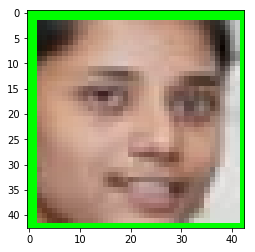

y16cs828


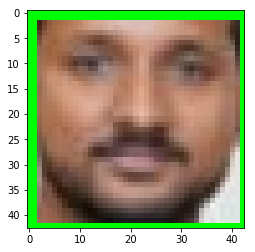

y16cs919


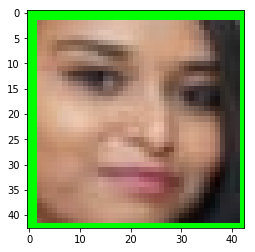

y16cs851


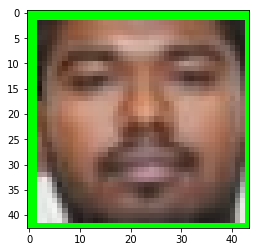

y16cs849


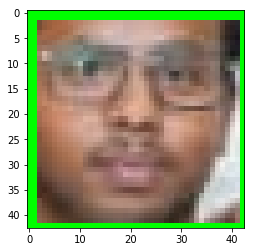

y16cs863


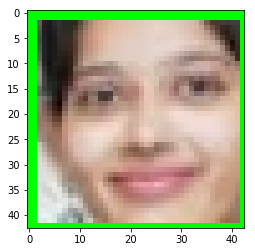

y16cs868


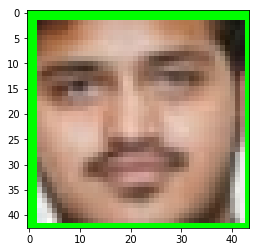

y16cs896


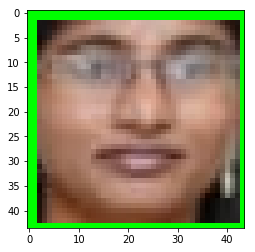

y16cs920


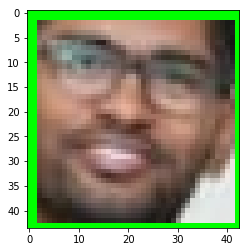

y16cs849


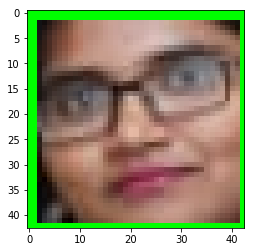

y16cs907
Done!!!!


In [22]:
img_path='Images/abc1.jpg'
modeldir = './Models/FaceRecognitionWeights.pb'
classifier_filename = 'classifier.pkl'
train_img="./Students/Train"
students=[]
with tf.Graph().as_default():
    sess = tf.Session()
    with sess.as_default():
        
        image_size = 182
        input_image_size = 160
        
        RegdNo = os.listdir(train_img)
        RegdNo.sort()

        print('Loading feature extraction model')
        load_model(modeldir)

        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        embedding_size = embeddings.get_shape()[1]


        classifier_filename_exp = os.path.expanduser(classifier_filename)
        with open(classifier_filename_exp, 'rb') as infile:
            (model, class_names) = pickle.load(infile)
        c = 0
        print('Start Recognition!')
        
        frame = cv2.imread(img_path)
        
        '''scale_percent=30
        width = int(frame.shape[1] * scale_percent / 100)
        height = int(frame.shape[0] * scale_percent / 100)
        dsize = (width, height)
        frame=cv2.resize(frame,dsize)'''

        find_results = []
        bounding_boxes = face_recognition.face_locations(frame)
        nrof_faces = len(bounding_boxes)
        det=bounding_boxes
        print('Face Detected: %d' % nrof_faces)

        if nrof_faces > 0:
            cropped = []
            scaled = []
            scaled_reshape = []
            bb = np.zeros((nrof_faces,4), dtype=np.int32)

            for i in range(nrof_faces):
                emb_array = np.zeros((1, embedding_size))

                bb[i][0] = det[i][0] #top
                bb[i][1] = det[i][1] #right
                bb[i][2] = det[i][2] #bottom
                bb[i][3] = det[i][3] #left

                cropped.append(frame[bb[i][0]:bb[i][2], bb[i][3]:bb[i][1], :])
                cropped[i] = flip(cropped[i])
                scaled.append(transform.resize(cropped[i], (image_size, image_size)))
                scaled[i] = cv2.resize(scaled[i], (input_image_size,input_image_size), interpolation=cv2.INTER_CUBIC)
                scaled[i] = prewhiten(scaled[i])
                scaled_reshape.append(scaled[i].reshape(-1,input_image_size,input_image_size,3))
                feed_dict = {images_placeholder: scaled_reshape[i], phase_train_placeholder: False}
                emb_array[0, :] = sess.run(embeddings, feed_dict=feed_dict)
                predictions = model.predict_proba(emb_array)
                best_class_indices = np.argmax(predictions, axis=1)
                best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
                cv2.rectangle(frame, (bb[i][3], bb[i][0]), (bb[i][1], bb[i][2]), (0, 255, 0), 2)
                face=frame[bb[i][0]:bb[i][2], bb[i][3]:bb[i][1]]
                plt.imshow(face[:,:,::-1])
                plt.show()
                text_x = bb[i][3]
                text_y = bb[i][2] + 20
                for reg in RegdNo:
                    if RegdNo[best_class_indices[0]] == reg:
                        result_names = RegdNo[best_class_indices[0]]
                        cv2.putText(frame, result_names, (text_x, text_y), cv2.FONT_HERSHEY_COMPLEX_SMALL,1, (0, 0, 255))
                        print(result_names)
                        students.append(result_names)
        else:
            print('No faces in photo')
    
    cv2.imshow('Image', frame)

    if cv2.waitKey(1000000) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
cv2.destroyAllWindows()
print("Done!!!!")

In [14]:
students=set(students)
students

{'y16cs828',
 'y16cs832',
 'y16cs851',
 'y16cs863',
 'y16cs868',
 'y16cs907',
 'y16cs919',
 'y16cs920'}

# Upload attendance in excel file

In [23]:
attendance=pd.read_excel('attendance.xlsx')
today=str(datetime.now())[:10]
attendance=attendance.set_index('RegdNo')
attendance[today]=['Absent']*180
for i in students:
    attendance.loc[i,today]='Present'
attendance.to_excel('attendance.xlsx')
attendance.iloc[27:68]

,2020-07-18,2020-07-19
RegdNo,,
y16cs828,Present,Present
y16cs829,Absent,Absent
y16cs830,Absent,Absent
y16cs831,Absent,Absent
y16cs832,Present,Absent
y16cs833,Absent,Absent
y16cs834,Absent,Absent
y16cs835,Absent,Absent
y16cs836,Absent,Absent
